In [1]:
import numpy as np

import pandas as pd

import random

from tqdm import tqdm

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.tri as mtri

from scipy.spatial import Delaunay

from sklearn.metrics import root_mean_squared_error

mpl.rcParams['font.family'] = 'serif'

# 3D N-stream Monte Carlo Simulation with Polyhedra clouds

#### Table of contents 
[1. Cube](#Cube-functions)  
[2. Sphere](#Sphere-functions)  
[3. Pyramid](#Pyramid-functions)  
[3. Run experiments](#Experiments) 

Create clouds of 3 different shapes: cube, sphere, and pyramid  
run 3d montecarlo simulation where 4 things can happen  
1. Reflect - if photon is moving upward when it exits the cloud
2. Transmit - if photon is moving downward when it exits the cloud
3. Absorb 
4. Side exit - if photon is moving orthogonal to top/bottom (unlikely)

In [2]:
# stolen from https://github.com/Edenhofer/monte-carlo-radiative-transfer/blob/master/henyey_#20825estein.py
def rand_mu(n=1, g=0.85):
    r = np.random.rand(n)
    return ((r * ((1 + g**2 - 2*g)**(-1/2) - (1 + g**2 + 2*g)**(-1/2)) + (1 + g**2 + 2*g)**(-1/2))**-2 - 1 - g**2) / (-2 * g)


def henyey(g, mu):
    return (1 - np.power(g, 2)) / np.power(1 + np.power(g, 2) - 2 * g * mu, 3/2)

In [3]:
g = 0.85 # from class
prob_back = (1-g)*0.5 # probability backscatter (low prob)
prob_fwd = (1+g)*0.5 # probability forward scatter (high prob)
omega = 0.99  # single-scattering albedo (0.99 = 1% chance of absorption)
num_sims = 10000  
optical_depth = 10  # optical depth for each side of the cube

# the below make the sphere and pyramid the same volume as the cube, based on the optical depth of cube
radius_sphere = optical_depth/((4/3*np.pi)**(1/3))
base_height_pyramid = (3*optical_depth**3)**(1/3) # height and base side lengths (equivalent for simplicity)

tau_array = [-np.log(1-random.uniform(0, 1)) for i in range(1000000)]

They should all have the same volume  
cube = s^3   
sphere = 4/3piR^3 # so R = 3S/((4pi)^(1/3))  
pyramid = 1/3 base_area*h # base_area = h^2; h = (3s^3)^(1/3)  

In [4]:
print(f"radius of sphere is {radius_sphere}\nbase&height of pyramid is {base_height_pyramid}\n")  
print(f"Volume of cube is {optical_depth**3}\nVolume of sphere is {round(4/3*np.pi*radius_sphere**3,0)}\nVolume of pyramid is {round((1/3)*base_height_pyramid**3, 0)}")

radius of sphere is 6.203504908994001
base&height of pyramid is 14.422495703074082

Volume of cube is 1000
Volume of sphere is 1000.0
Volume of pyramid is 1000.0


In [5]:
# animation function
def animate(i, shape, shape_flipped="no"):
    ax.clear()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'photons: {len(all_photon_paths)} \ng: {g}\nω₀: {omega}', weight="bold")
    
    # draw shape
    if shape.lower() == 'cube':
        # cube with length optical depth in x, y, and z
        for edge in cube_edges:
            ax.plot(*zip(*edge), color='black', alpha=0.3)
            
        ax.set_xlim(0, optical_depth)
        ax.set_ylim(0, optical_depth)
        ax.set_zlim(0, optical_depth)

        ax.xaxis.pane.set_edgecolor('lightgrey')
        ax.yaxis.pane.set_edgecolor('lightgrey')
        ax.zaxis.pane.set_edgecolor('lightgrey')
    elif shape.lower() == 'sphere':
        # radius and center at middle of cube
        center = [radius_sphere, radius_sphere, radius_sphere]
        radius = radius_sphere
        u = np.linspace(0, 2*np.pi, 20)
        v = np.linspace(0, np.pi, 20)
        x = center[0] + radius*np.outer(np.cos(u), np.sin(v))
        y = center[1] + radius*np.outer(np.sin(u), np.sin(v))
        z = center[2] + radius*np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_wireframe(x, y, z, color='black', alpha=0.3, rstride=2, cstride=2)
        
        ax.set_xlim(0, 2*radius)
        ax.set_ylim(0, 2*radius)
        ax.set_zlim(0, 2*radius)
        
        ax.xaxis.pane.set_edgecolor('lightgrey')
        ax.yaxis.pane.set_edgecolor('lightgrey')
        ax.zaxis.pane.set_edgecolor('lightgrey')
    elif shape.lower() == 'pyramid':
        # from https://stackoverflow.com/questions/29311682/finding-if-point-is-in-3d-poly-in-python
        x = np.array([0,0,base_height_pyramid/2,base_height_pyramid,base_height_pyramid]) 
        y = np.array([0,base_height_pyramid,base_height_pyramid/2,0,base_height_pyramid]) 
        z = np.array([0,0,base_height_pyramid,0,0]) 
        if shape_flipped == "yes": # photon coming down on top
            z = base_height_pyramid - z
        
        pyramid = Delaunay(np.array([x,y,z]).T)
        #ax.plot_trisurf(x, y, z, triangles=pyramid.simplices)
        ax.plot_trisurf(x, y, z, triangles=pyramid.simplices, color='none', edgecolor='gray', linewidth=1.0)
        
        ax.set_xlim(0, base_height_pyramid)
        ax.set_ylim(0, base_height_pyramid)
        ax.set_zlim(0, base_height_pyramid)
        
        ax.xaxis.pane.set_edgecolor('lightgrey')
        ax.yaxis.pane.set_edgecolor('lightgrey')
        ax.zaxis.pane.set_edgecolor('lightgrey')

    countR = 0
    countT = 0
    countA = 0
    countS = 0
    
    for j in range(min(i + 1, len(all_photon_paths))):
        xyz, result = all_photon_paths[j]
        xs, ys, zs = zip(*xyz)
        
        # color photon line by R T A
        if result == "R":
            color = '#2c3e50' 
            countR += 1
        elif result == "T":
            color = '#e74c3c' 
            countT += 1
        elif result == "A":
            color = '#f1c40f'  
            countA += 1
        else:
            color = '#16a085'  # side exit very unlikely
            countS += 1
            
        ax.plot(xs, ys, zs, color=color, alpha=0.9, zorder=2)

        # scattering markers - gray circles
        if len(xyz) > 2:
            ax.scatter(xs[1:-1], ys[1:-1], zs[1:-1], edgecolors='gray', facecolors='none', s=15, alpha=0.35, zorder=1)
        ax.scatter(xs[-1], ys[-1], zs[-1], color=color, s=20, zorder=3)

    # photon counter - tracks % R T A
    totalPh = countR + countT + countA + countS
    pctR = round(100*countR/totalPh, 0) # pct reflected, dynamic
    pctT = round(100*countT/totalPh, 0) # pct T
    pctA = round(100*countA/totalPh, 0) # pct A
    pctS = round(100*countS/totalPh, 0) # pct S
    counter_text = f"Total: {totalPh}/{num_sims}\nReflected: {pctR}%\nTransmitted: {pctT}%\nAbsorbed: {pctA}%\nHorizontal: {pctS}%"
    ax.text2D(.98, .08, counter_text, transform=ax.transAxes, fontsize=10,
              bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

    legend_elements = [
        Line2D([0], [0], color='#2c3e50', lw=1.5, label='Reflected'),
        Line2D([0], [0], color='#e74c3c', lw=1.5, label='Transmitted'),
        Line2D([0], [0], color='#f1c40f', lw=1.5, label='Absorbed'),
        Line2D([0], [0], color='#16a085', lw=1.5, label='Perfect horizontal exit'),
        Line2D([0], [0], color='gray', marker='o', alpha=0.4, lw=0, label='Scattering event')]
    ax.legend(handles=legend_elements, loc=[.9, .9], frameon=False, prop={'size': 9})

    #if shape_flipped == "no":
    plt.gca().invert_zaxis() # make it appear as photon coming down from top

## Cube functions

In [6]:
def monte_carlo_3D_cube():
    '''
    single photon simulation in cube medium
    all sides = optical depth
    '''
    # start at random position on top of shape
    x = optical_depth/2 #random.uniform(0, optical_depth)
    y = optical_depth/2 #random.uniform(0, optical_depth)
    z = 0
    
    # initial direction is downward
    theta = 0  # polar angle - start directly down
    phi = 0    # azimuthal angle
    xyz = [(x, y, z)]
    numscat = 0 # number scattering events
    
    while True:  
        # sample tau
        scattau = random.choice(tau_array)
        
        # use current direction to calculate position change
        change_tau_x = scattau*np.sin(theta)*np.cos(phi)
        change_tau_y = scattau*np.sin(theta)*np.sin(phi)
        change_tau_z = scattau*np.cos(theta)
        
        # get new global position
        newx = x + change_tau_x
        newy = y + change_tau_y
        newz = z + change_tau_z
        
        # has photon hit cube boundary? 
        if (newx >= optical_depth or newx <= 0 or # exits R/L 
            newy >= optical_depth or newy <= 0 or # exits back/front 
            newz >= optical_depth or newz <= 0): # exits top/bottom
            
            # Add the boundary intersection to the xyz
            # calculate intersection point? (maybe implement in future if necessary)
            # add the new position for simplicity
            xyz.append((newx, newy, newz))
            
            # which exit? (reflection, transmission, or side)
            if newz <= 0:
                result = "R"  
            elif newz >= optical_depth:
                result = "T"  
            else: # goes out the side
                # check the Z direction it is going to see if T or R
                if change_tau_z > 0:
                    result = "T"
                elif change_tau_z < 0:
                    result = "R"
                else: # goes perfectly out side, orthogonal to top and bottom 
                    result = "S"  # exit through side
                
            return xyz, result, numscat # return statement here !!
        
        # if did not exit, update position in cloud
        x, y, z = newx, newy, newz
        xyz.append((x, y, z))
        
        # absorbed?
        if random.uniform(0, 1) > omega:
            return xyz, "A", numscat  # return statement here !!

        # if not absorbed determine how much backward or forward the scattering occurs
        cos_scat = rand_mu(1, g)[0]  # get rand mu
        sin_scat = np.sqrt(1.0 - cos_scat**2)
        
        # get directions from theta and phi
        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        sin_phi = np.sin(phi)
        cos_phi = np.cos(phi)
        
        # get local scattering direction relative to theta/phi
        phi_scatter = 2.0*np.pi*np.random.random() 
        cos_phi_scat = np.cos(phi_scatter)
        sin_phi_scat = np.sin(phi_scatter)
        
        # convert direction to global xyz direction
        newx = sin_theta*cos_phi*cos_scat + (cos_theta*cos_phi*cos_phi_scat - sin_phi*sin_phi_scat)*sin_scat
        newy = sin_theta*sin_phi*cos_scat + (cos_theta*sin_phi*cos_phi_scat + cos_phi*sin_phi_scat)*sin_scat
        newz = cos_theta*cos_scat - sin_theta*sin_scat*cos_phi_scat
        
        # convert to spherical coordinates for next iteration
        theta = np.arccos(newz)
        phi = np.arctan2(newy, newx)
        numscat = numscat + 1

## Sphere functions

In [7]:
class sphere:
    def __init__(self, center, radius_sphere):
        self.center = np.array(center)
        self.radius = radius_sphere
    
    def is_inside(self, point):
        point = np.array(point)
        # distance from the center will need to be less than the radius for it to be in the sphere
        distance = np.linalg.norm(point - self.center)
        return distance <= self.radius

In [8]:
def monte_carlo_3D_sphere():
    '''
    single photon simulation in sphere
    '''
    # start at random position on top of shape
    x = radius_sphere #random.uniform(0, optical_depth)
    y = radius_sphere #random.uniform(0, optical_depth)
    z = 0
    
    # initial direction is downward
    theta = 0  # polar angle - start directly down
    phi = 0    # azimuthal angle
    xyz = [(x, y, z)]
    numscat = 0 # number scattering events

    # create sphere
    sphere_cloud = sphere([radius_sphere, radius_sphere, radius_sphere], radius_sphere)
    while True:  
        # sample tau
        scattau = random.choice(tau_array)
        
        # use current direction to calculate position change
        change_tau_x = scattau*np.sin(theta)*np.cos(phi)
        change_tau_y = scattau*np.sin(theta)*np.sin(phi)
        change_tau_z = scattau*np.cos(theta)
        
        # get new global position
        newx = x + change_tau_x
        newy = y + change_tau_y
        newz = z + change_tau_z

        # has photon hit sphere boundary? 
        if not sphere_cloud.is_inside([newx, newy, newz]):
            
            # Add the boundary intersection to the xyz
            # calculate intersection point? (maybe implement in future if necessary)
            # add the new position for simplicity
            xyz.append((newx, newy, newz))
            
            # which exit? (reflection, transmission, or side)
            if newz <= 0:
                result = "R"  
            elif newz >= optical_depth:
                result = "T"  
            else: # goes out the side
                # check the Z direction it is going to see if T or R
                if change_tau_z > 0:
                    result = "T"
                elif change_tau_z < 0:
                    result = "R"
                else: # goes perfectly out side, orthogonal to top and bottom 
                    result = "S"  # exit through side
                
            return xyz, result, numscat # return statement here !!
        
        # if did not exit, update position in cloud
        x, y, z = newx, newy, newz
        xyz.append((x, y, z))
        
        # absorbed?
        if random.uniform(0, 1) > omega:
            return xyz, "A", numscat  # return statement here !!

        # if not absorbed determine how much backward or forward the scattering occurs
        cos_scat = rand_mu(1, g)[0]  # get rand mu
        sin_scat = np.sqrt(1.0 - cos_scat**2)
        
        # get directions from theta and phi
        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        sin_phi = np.sin(phi)
        cos_phi = np.cos(phi)
        
        # get local scattering direction relative to theta/phi
        phi_scatter = 2.0*np.pi*np.random.random() 
        cos_phi_scat = np.cos(phi_scatter)
        sin_phi_scat = np.sin(phi_scatter)
        
        # convert direction to global xyz direction
        newx = sin_theta*cos_phi*cos_scat + (cos_theta*cos_phi*cos_phi_scat - sin_phi*sin_phi_scat)*sin_scat
        newy = sin_theta*sin_phi*cos_scat + (cos_theta*sin_phi*cos_phi_scat + cos_phi*sin_phi_scat)*sin_scat
        newz = cos_theta*cos_scat - sin_theta*sin_scat*cos_phi_scat
        
        # convert to spherical coordinates for next iteration
        theta = np.arccos(newz)
        phi = np.arctan2(newy, newx)
        numscat=numscat+1

## Pyramid functions

In [62]:
class pyramid:
    from scipy.spatial import Delaunay
    def __init__(self, base_height_pyramid=base_height_pyramid, direction="normal"):
        x = np.array([0,0,base_height_pyramid/2,base_height_pyramid,base_height_pyramid]) 
        y = np.array([0,base_height_pyramid,base_height_pyramid/2,0,base_height_pyramid]) 
        z = np.array([0,0,base_height_pyramid,0,0]) 
        
        if direction == "flipped": # flip pyramid upside down
            z = base_height_pyramid - z
        
        self.shape = Delaunay(np.array([x, y, z]).T)
    
    def is_inside(self, point):
        point = np.array(point)
        # use delauney triangulation to see if point inside or outside
        # from old post https://stackoverflow.com/questions/26434726/return-surface-triangle-of-3d-scipy-spatial-delaunay
        boolean = self.shape.find_simplex(point) >= 0
        return boolean == True

In [58]:
def monte_carlo_3D_pyramid_top():
    from scipy.spatial import Delaunay
    '''
    single photon simulation in pyramid coming down on the top of the pyramid
    '''
    # start at random position on top of shape
    x = base_height_pyramid/2 #random.uniform(0, optical_depth)
    y = base_height_pyramid/2 #random.uniform(0, optical_depth)
    z = 0
    
    # initial direction is downward
    theta = 0  # polar angle - start directly down
    phi = 0    # azimuthal angle
    xyz = [(x, y, z)]
    numscat = 0 # number scattering events

    # create pyramid
    pyramid_cloud = pyramid(base_height_pyramid=base_height_pyramid, direction="flipped") # flip so photons go through top first 
    while True:  
        # sample tau"
        scattau = random.choice(tau_array)
        
        # use current direction to calculate position change
        change_tau_x = scattau*np.sin(theta)*np.cos(phi)
        change_tau_y = scattau*np.sin(theta)*np.sin(phi)
        change_tau_z = scattau*np.cos(theta)
        
        # get new global position
        newx = x + change_tau_x
        newy = y + change_tau_y
        newz = z + change_tau_z

        # has photon hit pyramid boundary? 
        if not pyramid_cloud.is_inside([newx, newy, newz]):
            
            # Add the boundary intersection to the xyz
            # calculate intersection point? (maybe implement in future if necessary)
            # add the new position for simplicity
            xyz.append((newx, newy, newz))
            
            # which exit? (reflection, transmission, or side)
            if newz <= 0:
                result = "R"  
            elif newz >= optical_depth:
                result = "T"  
            else: # goes out the side
                # check the Z direction it is going to see if T or R
                if change_tau_z > 0:
                    result = "T"
                elif change_tau_z < 0:
                    result = "R"
                else: # goes perfectly out side, orthogonal to top and bottom 
                    result = "S"  # exit through side
                
            return xyz, result, numscat # return statement here !!
        
        # if did not exit, update position in cloud
        x, y, z = newx, newy, newz
        xyz.append((x, y, z))
        
        # absorbed?
        if random.uniform(0, 1) > omega:
            return xyz, "A", numscat  # return statement here !!

        # if not absorbed determine how much backward or forward the scattering occurs
        cos_scat = rand_mu(1, g)[0]  # get rand mu
        sin_scat = np.sqrt(1.0 - cos_scat**2)
        
        # get directions from theta and phi
        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        sin_phi = np.sin(phi)
        cos_phi = np.cos(phi)
        
        # get local scattering direction relative to theta/phi
        phi_scatter = 2.0*np.pi*np.random.random() 
        cos_phi_scat = np.cos(phi_scatter)
        sin_phi_scat = np.sin(phi_scatter)
        
        # convert direction to global xyz direction
        newx = sin_theta*cos_phi*cos_scat + (cos_theta*cos_phi*cos_phi_scat - sin_phi*sin_phi_scat)*sin_scat
        newy = sin_theta*sin_phi*cos_scat + (cos_theta*sin_phi*cos_phi_scat + cos_phi*sin_phi_scat)*sin_scat
        newz = cos_theta*cos_scat - sin_theta*sin_scat*cos_phi_scat
        
        # convert to spherical coordinates for next iteration
        theta = np.arccos(newz)
        phi = np.arctan2(newy, newx)
        numscat=numscat+1

In [59]:
def monte_carlo_3D_pyramid_bottom():
    from scipy.spatial import Delaunay
    '''
    single photon simulation in pyramid coming up from the base of the pyramid
    '''
    # start at random position on top of shape
    x = base_height_pyramid/2 #random.uniform(0, optical_depth)
    y = base_height_pyramid/2 #random.uniform(0, optical_depth)
    z = 0
    
    # initial direction is downward
    theta = 0  # polar angle - start directly down
    phi = 0    # azimuthal angle
    xyz = [(x, y, z)]
    numscat = 0 # number scattering events

    # create sphere
    pyramid_cloud = pyramid(base_height_pyramid)
    while True:  
        # sample tau
        scattau = random.choice(tau_array)
        
        # use current direction to calculate position change
        change_tau_x = scattau*np.sin(theta)*np.cos(phi)
        change_tau_y = scattau*np.sin(theta)*np.sin(phi)
        change_tau_z = scattau*np.cos(theta)
        
        # get new global position
        newx = x + change_tau_x
        newy = y + change_tau_y
        newz = z + change_tau_z

        # has photon hit pyramid boundary? 
        if not pyramid_cloud.is_inside([newx, newy, newz]):
            
            # Add the boundary intersection to the xyz
            # calculate intersection point? (maybe implement in future if necessary)
            # add the new position for simplicity
            xyz.append((newx, newy, newz))
            
            # which exit? (reflection, transmission, or side)
            if newz <= 0:
                result = "R"  
            elif newz >= optical_depth:
                result = "T"  
            else: # goes out the side
                # check the Z direction it is going to see if T or R
                if change_tau_z > 0:
                    result = "T"
                elif change_tau_z < 0:
                    result = "R"
                else: # goes perfectly out side, orthogonal to top and bottom 
                    result = "S"  # exit through side
                
            return xyz, result, numscat # return statement here !!
        
        # if did not exit, update position in cloud
        x, y, z = newx, newy, newz
        xyz.append((x, y, z))
        
        # absorbed?
        if random.uniform(0, 1) > omega:
            return xyz, "A", numscat  # return statement here !!

        # if not absorbed determine how much backward or forward the scattering occurs
        cos_scat = rand_mu(1, g)[0]  # get rand mu
        sin_scat = np.sqrt(1.0 - cos_scat**2)
        
        # get directions from theta and phi
        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        sin_phi = np.sin(phi)
        cos_phi = np.cos(phi)
        
        # get local scattering direction relative to theta/phi
        phi_scatter = 2.0*np.pi*np.random.random() 
        cos_phi_scat = np.cos(phi_scatter)
        sin_phi_scat = np.sin(phi_scatter)
        
        # convert direction to global xyz direction
        newx = sin_theta*cos_phi*cos_scat + (cos_theta*cos_phi*cos_phi_scat - sin_phi*sin_phi_scat)*sin_scat
        newy = sin_theta*sin_phi*cos_scat + (cos_theta*sin_phi*cos_phi_scat + cos_phi*sin_phi_scat)*sin_scat
        newz = cos_theta*cos_scat - sin_theta*sin_scat*cos_phi_scat
        
        # convert to spherical coordinates for next iteration
        theta = np.arccos(newz)
        phi = np.arctan2(newy, newx)
        numscat = numscat + 1

## Run simulation func

In [60]:
def runMCsim(func, num_sims, print_stmt=None):
    # run cube montecarlo sim
    R_array = []  
    T_array = [] 
    A_array = []  
    
    all_photon_paths = []
    
    # Simulate photons and collect paths
    print("Simulating photon paths...")
    numR = 0
    numT = 0
    numA = 0
    numS = 0  # Count of photons exiting through sides
    num_scattered = 0
    
    for _ in tqdm(range(num_sims)):
        xyz, result, scat = func()
        
        # Record the result
        if result == "R":
            numR += 1
        elif result == "T":
            numT += 1
        elif result == "A":
            numA += 1
        elif result == "S":
            numS += 1
        num_scattered = num_scattered + scat 
        # Store the xyz for visualization
        all_photon_paths.append((xyz, result))
    
    # Calculate fractions
    R_fraction = numR / num_sims
    T_fraction = numT / num_sims
    A_fraction = numA / num_sims
    S_fraction = numS / num_sims
    
    print(f"{print_stmt}")
    print(f"Reflection: {R_fraction:.4f}")
    print(f"Transmission: {T_fraction:.4f}")
    print(f"Absorption: {A_fraction:.4f}")
    print(f"Side exit: {S_fraction:.4f}")
    print(f"Number scattered: {num_scattered}")
    print(f"Conservation check: {R_fraction + T_fraction + A_fraction + S_fraction:.4f}")

    return all_photon_paths, R_fraction, T_fraction, A_fraction, S_fraction, num_scattered

## Experiments

#### Cube exp

In [61]:
printstmt = f"Results for cubic medium with optical depth {round(optical_depth, 1)}:"
all_photon_paths, R_fraction, T_fraction, A_fraction, S_fraction, nscat = runMCsim(monte_carlo_3D_cube, 
                                                                            num_sims, printstmt
                                                                           )

Simulating photon paths...


100%|█████████████████████████████████| 100000/100000 [00:11<00:00, 8456.44it/s]

Results for cubic medium with optical depth 10:
Reflection: 0.3376
Transmission: 0.5613
Absorption: 0.1011
Side exit: 0.0000
Number scattered: 1006301
Conservation check: 1.0000


In [39]:
# !! Uncomment to create photon animation !!

# ani_name = f"animations/cube_animation_photons-{len(all_photon_paths)}_tau-{optical_depth}.mp4"
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# #draw cube edges hard coded for animation
# # from https://how2matplotlib.com/how-to-draw-3d-cube-using-matplotlib-in-python.html
# cube_edges = [
#     [(0, 0, 0), (optical_depth, 0, 0)],
#     [(0, 0, 0), (0, optical_depth, 0)],
#     [(0, 0, 0), (0, 0, optical_depth)],
#     [(optical_depth, 0, 0), (optical_depth, optical_depth, 0)],
#     [(optical_depth, 0, 0), (optical_depth, 0, optical_depth)],
#     [(0, optical_depth, 0), (optical_depth, optical_depth, 0)],
#     [(0, optical_depth, 0), (0, optical_depth, optical_depth)],
#     [(0, 0, optical_depth), (optical_depth, 0, optical_depth)],
#     [(0, 0, optical_depth), (0, optical_depth, optical_depth)],
#     [(optical_depth, optical_depth, 0), (optical_depth, optical_depth, optical_depth)],
#     [(optical_depth, 0, optical_depth), (optical_depth, optical_depth, optical_depth)],
#     [(0, optical_depth, optical_depth), (optical_depth, optical_depth, optical_depth)]]

# print("creating animation...")
# anim = FuncAnimation(fig, lambda i: animate(i, shape='cube'), frames=len(all_photon_paths), interval=30, blit=False)
# print("saving animation...")
# anim.save(ani_name, writer='ffmpeg', fps=10)
# print(f"saved {ani_name}")

#### Sphere exp

In [54]:
printstmt = f"Results for spherical medium with radius {radius_sphere}:"
all_photon_paths, R_fraction, T_fraction, A_fraction, S_fraction, nscat = runMCsim(monte_carlo_3D_sphere, 
                                                                            num_sims, printstmt
                                                                           )

Simulating photon paths...


100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 6827.81it/s]

Results for spherical medium with radius 6.203504908994001:
Reflection: 0.3669
Transmission: 0.5296
Absorption: 0.1035
Side exit: 0.0000
Conservation check: 1.0000


In [44]:
# !! Uncomment to create animation !!
# # create photon animation
# ani_name = f"animations/sphere_animation_photons-{len(all_photon_paths)}_tau-{optical_depth}.mp4"
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# print("creating animation...")
# anim = FuncAnimation(fig, lambda i: animate(i, shape='sphere'), frames=len(all_photon_paths), interval=30, blit=False)
# print("saving animation...")
# anim.save(ani_name, writer='ffmpeg', fps=10)
# print(f"saved {ani_name}")

#### Pyramid top exp

In [19]:
printstmt = f"Results for a pyramid medium with base/height {round(base_height_pyramid, 1)}:"
all_photon_paths, R_fraction, T_fraction, A_fraction, S_fraction, nscat = runMCsim(monte_carlo_3D_pyramid_top, 
                                                                            num_sims, printstmt
                                                                           )

Simulating photon paths...


100%|███████████████████████████████████████| 250/250 [00:00<00:00, 9204.01it/s]

Results for a pyramid medium with base/height 21.6:
Reflection: 0.0000
Transmission: 1.0000
Absorption: 0.0000
Side exit: 0.0000
Number scattered: 0
Conservation check: 1.0000


In [64]:
# #!! Uncomment to create animation !!
# ani_name = f"animations/pyramid_top_animation_photons-{len(all_photon_paths)}_baseheight-{round(base_height_pyramid, 0)}.mp4"
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# print("creating animation...")
# anim = FuncAnimation(fig, lambda i: animate(i, shape='pyramid', shape_flipped="yes"), frames=len(all_photon_paths), interval=30, blit=False)
# print("saving animation...")
# anim.save(ani_name, writer='ffmpeg', fps=10)
# print(f"saved {ani_name}")

#### Pyramid bottom exp

In [56]:
printstmt = f"Results for a flipped pyramid medium with base/height {round(base_height_pyramid, 1)}:"
all_photon_paths, R_fraction, T_fraction, A_fraction, S_fraction, nscat = runMCsim(monte_carlo_3D_pyramid_bottom, 
                                                                            num_sims, printstmt
                                                                           )

Simulating photon paths...


100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 6710.03it/s]

Results for a flipped pyramid medium with base/height 14.4:
Reflection: 0.2981
Transmission: 0.6046
Absorption: 0.0973
Side exit: 0.0000
Conservation check: 1.0000


In [35]:
# !! Uncomment to create animation !!
# ani_name = f"animations/pyramid_bottom_animation_photons-{len(all_photon_paths)}_baseheight-{round(base_height_pyramid, 0)}.mp4"
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# print("creating animation...")
# anim = FuncAnimation(fig, lambda i: animate(i, shape='pyramid'), frames=len(all_photon_paths), interval=30, blit=False)
# print("saving animation...")
# anim.save(ani_name, writer='ffmpeg', fps=10)
# print(f"saved {ani_name}")

## Analysis

In [67]:
# 125 volume
optical_depth = 5  # optical depth for each side of the cube
# the below make the sphere and pyramid the same volume as the cube, based on the optical depth of cube
radius_sphere = optical_depth/((4/3*np.pi)**(1/3))
base_height_pyramid = (3*optical_depth**3)**(1/3) # height and base side lengths (equivalent for simplicity)

### !! Bug alert !!
# bug in code that requires re-running the pyramid function after resetting the base/height measurements
# due to set up of function and improper handlind of global variables inside local functions (which jupyter notebook allows)
# the whole notebook should be revamped to avoid these issues, but for times sake quick and dirty fix is to reset the function
class pyramid:
    from scipy.spatial import Delaunay
    def __init__(self, base_height_pyramid=base_height_pyramid, direction="normal"):
        x = np.array([0,0,base_height_pyramid/2,base_height_pyramid,base_height_pyramid]) 
        y = np.array([0,base_height_pyramid,base_height_pyramid/2,0,base_height_pyramid]) 
        z = np.array([0,0,base_height_pyramid,0,0]) 
        
        if direction == "flipped": # flip pyramid upside down
            z = base_height_pyramid - z
        
        self.shape = Delaunay(np.array([x, y, z]).T)
    
    def is_inside(self, point):
        point = np.array(point)
        # use delauney triangulation to see if point inside or outside
        # from old post https://stackoverflow.com/questions/26434726/return-surface-triangle-of-3d-scipy-spatial-delaunay
        boolean = self.shape.find_simplex(point) >= 0
        return boolean == True
## Squash bug later

# run sum
num_sims = 100000
all_photon_paths_C5, R_fraction_C5, T_fraction_C5, A_fraction_C5, S_fraction_C5, nscat_C5 = runMCsim(monte_carlo_3D_cube, 
                                                                            num_sims)
all_photon_paths_S5, R_fraction_S5, T_fraction_S5, A_fraction_S5, S_fraction_S5, nscat_S5 = runMCsim(monte_carlo_3D_sphere, 
                                                                            num_sims)
all_photon_paths_PT5, R_fraction_PT5, T_fraction_PT5, A_fraction_PT5, S_fraction_PT5, nscat_PT5 = runMCsim(monte_carlo_3D_pyramid_top, 
                                                                            num_sims)
all_photon_paths_PB5, R_fraction_PB5, T_fraction_PB5, A_fraction_PB5, S_fraction_PB5, nscat_PB5 = runMCsim(monte_carlo_3D_pyramid_bottom, 
                                                                            num_sims)

Simulating photon paths...


100%|████████████████████████████████| 100000/100000 [00:06<00:00, 16000.09it/s]


None
Reflection: 0.1972
Transmission: 0.7503
Absorption: 0.0524
Side exit: 0.0000
Number scattered: 511632
Conservation check: 1.0000
Simulating photon paths...


100%|████████████████████████████████| 100000/100000 [00:07<00:00, 12565.84it/s]


None
Reflection: 0.2141
Transmission: 0.7304
Absorption: 0.0555
Side exit: 0.0000
Number scattered: 551474
Conservation check: 1.0000
Simulating photon paths...


100%|█████████████████████████████████| 100000/100000 [00:10<00:00, 9707.10it/s]


None
Reflection: 0.1922
Transmission: 0.7555
Absorption: 0.0524
Side exit: 0.0000
Number scattered: 518607
Conservation check: 1.0000
Simulating photon paths...


100%|████████████████████████████████| 100000/100000 [00:09<00:00, 10650.48it/s]

None
Reflection: 0.1758
Transmission: 0.7757
Absorption: 0.0485
Side exit: 0.0000
Number scattered: 495979
Conservation check: 1.0000


In [68]:
# 10000 volume
optical_depth = 10  # optical depth for each side of the cube
# the below make the sphere and pyramid the same volume as the cube, based on the optical depth of cube
radius_sphere = optical_depth/((4/3*np.pi)**(1/3))
base_height_pyramid = (3*optical_depth**3)**(1/3) # height and base side lengths (equivalent for simplicity)

### !! Bug alert !!
# bug in code that requires re-running the pyramid function after resetting the base/height measurements
# due to set up of function and improper handlind of global variables inside local functions (which jupyter notebook allows)
# the whole notebook should be revamped to avoid these issues, but for times sake quick and dirty fix is to reset the function
class pyramid:
    from scipy.spatial import Delaunay
    def __init__(self, base_height_pyramid=base_height_pyramid, direction="normal"):
        x = np.array([0,0,base_height_pyramid/2,base_height_pyramid,base_height_pyramid]) 
        y = np.array([0,base_height_pyramid,base_height_pyramid/2,0,base_height_pyramid]) 
        z = np.array([0,0,base_height_pyramid,0,0]) 
        
        if direction == "flipped": # flip pyramid upside down
            z = base_height_pyramid - z
        
        self.shape = Delaunay(np.array([x, y, z]).T)
    
    def is_inside(self, point):
        point = np.array(point)
        # use delauney triangulation to see if point inside or outside
        # from old post https://stackoverflow.com/questions/26434726/return-surface-triangle-of-3d-scipy-spatial-delaunay
        boolean = self.shape.find_simplex(point) >= 0
        return boolean == True
## Squash bug later


# run sum
num_sims = 100000
all_photon_paths_C10, R_fraction_C10, T_fraction_C10, A_fraction_C10, S_fraction_C10, nscat_C10 = runMCsim(monte_carlo_3D_cube, 
                                                                            num_sims)
all_photon_paths_S10, R_fraction_S10, T_fraction_S10, A_fraction_S10, S_fraction_S10, nscat_S10 = runMCsim(monte_carlo_3D_sphere, 
                                                                            num_sims)
all_photon_paths_PT10, R_fraction_PT10, T_fraction_PT10, A_fraction_PT10, S_fraction_PT10, nscat_PT10 = runMCsim(monte_carlo_3D_pyramid_top, 
                                                                            num_sims)
all_photon_paths_PB10, R_fraction_PB10, T_fraction_PB10, A_fraction_PB10, S_fraction_PB10, nscat_PB10 = runMCsim(monte_carlo_3D_pyramid_bottom, 
                                                                            num_sims)

Simulating photon paths...


100%|█████████████████████████████████| 100000/100000 [00:11<00:00, 8591.45it/s]


None
Reflection: 0.3407
Transmission: 0.5593
Absorption: 0.1000
Side exit: 0.0000
Number scattered: 1004435
Conservation check: 1.0000
Simulating photon paths...


100%|█████████████████████████████████| 100000/100000 [00:15<00:00, 6660.70it/s]


None
Reflection: 0.3719
Transmission: 0.5253
Absorption: 0.1028
Side exit: 0.0000
Number scattered: 1023481
Conservation check: 1.0000
Simulating photon paths...


100%|█████████████████████████████████| 100000/100000 [00:12<00:00, 8282.47it/s]


None
Reflection: 0.2761
Transmission: 0.6495
Absorption: 0.0744
Side exit: 0.0000
Number scattered: 729355
Conservation check: 1.0000
Simulating photon paths...


100%|█████████████████████████████████| 100000/100000 [00:14<00:00, 6916.98it/s]

None
Reflection: 0.2961
Transmission: 0.6072
Absorption: 0.0968
Side exit: 0.0000
Number scattered: 949390
Conservation check: 1.0000


In [69]:
# 3375 volume
optical_depth = 15  # optical depth for each side of the cube
# the below make the sphere and pyramid the same volume as the cube, based on the optical depth of cube
radius_sphere = optical_depth/((4/3*np.pi)**(1/3))
base_height_pyramid = (3*optical_depth**3)**(1/3) # height and base side lengths (equivalent for simplicity)

### !! Bug alert !!
# bug in code that requires re-running the pyramid function after resetting the base/height measurements
# due to set up of function and improper handlind of global variables inside local functions (which jupyter notebook allows)
# the whole notebook should be revamped to avoid these issues, but for times sake quick and dirty fix is to reset the function
class pyramid:
    from scipy.spatial import Delaunay
    def __init__(self, base_height_pyramid=base_height_pyramid, direction="normal"):
        x = np.array([0,0,base_height_pyramid/2,base_height_pyramid,base_height_pyramid]) 
        y = np.array([0,base_height_pyramid,base_height_pyramid/2,0,base_height_pyramid]) 
        z = np.array([0,0,base_height_pyramid,0,0]) 
        
        if direction == "flipped": # flip pyramid upside down
            z = base_height_pyramid - z
        
        self.shape = Delaunay(np.array([x, y, z]).T)
    
    def is_inside(self, point):
        point = np.array(point)
        # use delauney triangulation to see if point inside or outside
        # from old post https://stackoverflow.com/questions/26434726/return-surface-triangle-of-3d-scipy-spatial-delaunay
        boolean = self.shape.find_simplex(point) >= 0
        return boolean == True
## Squash bug later


# run sum
num_sims = 100000
all_photon_paths_C15, R_fraction_C15, T_fraction_C15, A_fraction_C15, S_fraction_C15, nscat_C15 = runMCsim(monte_carlo_3D_cube, 
                                                                            num_sims)
all_photon_paths_S15, R_fraction_S15, T_fraction_S15, A_fraction_S15, S_fraction_S15, nscat_S15 = runMCsim(monte_carlo_3D_sphere, 
                                                                            num_sims)
all_photon_paths_PT15, R_fraction_PT15, T_fraction_PT15, A_fraction_PT15, S_fraction_PT15, nscat_PT15 = runMCsim(monte_carlo_3D_pyramid_top, 
                                                                            num_sims)
all_photon_paths_PB15, R_fraction_PB15, T_fraction_PB15, A_fraction_PB15, S_fraction_PB15, nscat_PB15 = runMCsim(monte_carlo_3D_pyramid_bottom, 
                                                                            num_sims)

Simulating photon paths...


100%|█████████████████████████████████| 100000/100000 [00:17<00:00, 5774.34it/s]


None
Reflection: 0.4197
Transmission: 0.4326
Absorption: 0.1477
Side exit: 0.0000
Number scattered: 1468856
Conservation check: 1.0000
Simulating photon paths...


100%|█████████████████████████████████| 100000/100000 [00:19<00:00, 5080.53it/s]


None
Reflection: 0.4637
Transmission: 0.3886
Absorption: 0.1477
Side exit: 0.0000
Number scattered: 1452603
Conservation check: 1.0000
Simulating photon paths...


100%|█████████████████████████████████| 100000/100000 [00:13<00:00, 7676.88it/s]


None
Reflection: 0.3100
Transmission: 0.6071
Absorption: 0.0829
Side exit: 0.0000
Number scattered: 813355
Conservation check: 1.0000
Simulating photon paths...


100%|█████████████████████████████████| 100000/100000 [00:20<00:00, 4843.41it/s]

None
Reflection: 0.3724
Transmission: 0.4846
Absorption: 0.1429
Side exit: 0.0000
Number scattered: 1417203
Conservation check: 1.0000


In [123]:
bar.get_width()

np.float64(0.75034)

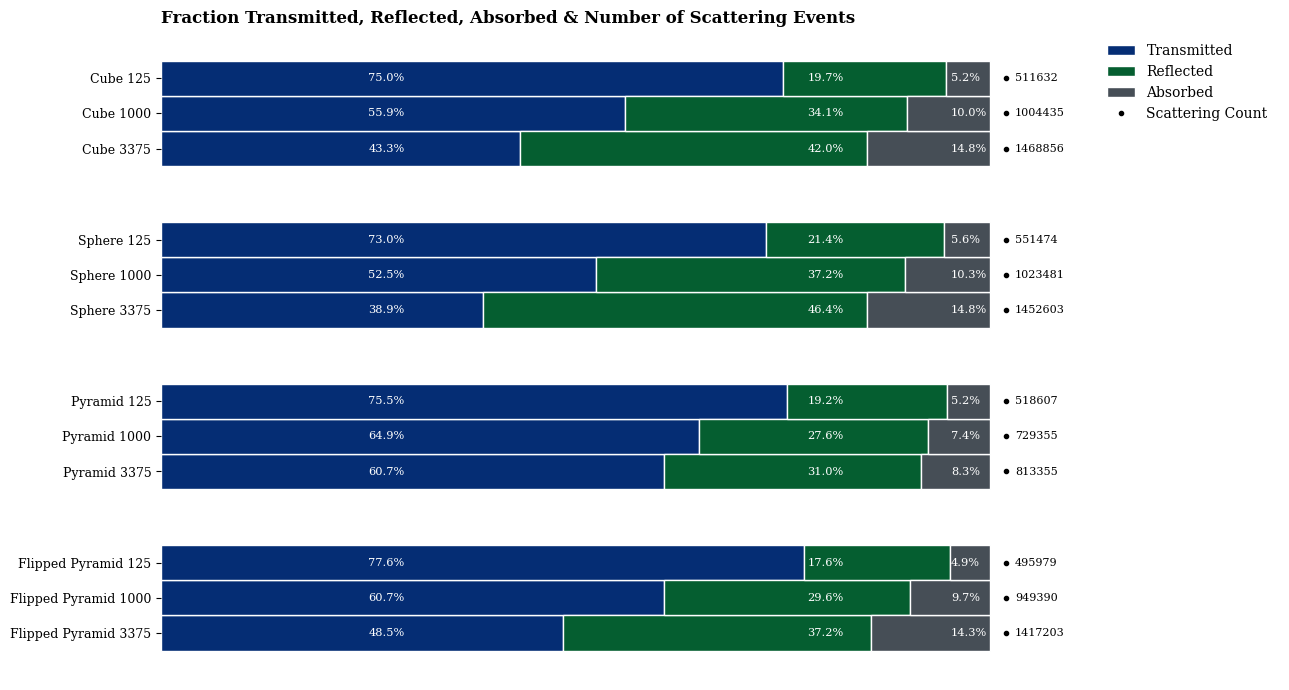

In [188]:
shapes = ['Flipped Pyramid', 'Pyramid', 'Sphere', 'Cube']
volumes = ['125', '1000', '3375']

fractions_RTA = {
    'Flipped Pyramid': [[R_fraction_PB5, T_fraction_PB5, A_fraction_PB5], [ R_fraction_PB10, T_fraction_PB10, A_fraction_PB10], [ R_fraction_PB15, T_fraction_PB15, A_fraction_PB15]],
    'Pyramid': [[R_fraction_PT5, T_fraction_PT5, A_fraction_PT5], [ R_fraction_PT10, T_fraction_PT10, A_fraction_PT10], [ R_fraction_PT15, T_fraction_PT15, A_fraction_PT15]],
    'Sphere': [[R_fraction_S5, T_fraction_S5, A_fraction_S5], [ R_fraction_S10, T_fraction_S10, A_fraction_S10], [ R_fraction_S15, T_fraction_S15, A_fraction_S15]],
    'Cube': [[R_fraction_C5, T_fraction_C5, A_fraction_C5], [ R_fraction_C10, T_fraction_C10, A_fraction_C10], [ R_fraction_C15, T_fraction_C15, A_fraction_C15]],
}

scattered_counts = {
    'Flipped Pyramid': [nscat_PB5, nscat_PB10, nscat_PB15],
    'Pyramid': [nscat_PT5, nscat_PT10, nscat_PT15],
    'Sphere': [nscat_S5, nscat_S10, nscat_S15],
    'Cube': [nscat_C5, nscat_C10, nscat_C15],
}
colors = ['#052D74', '#055E30', '#464E56']  # T, R, A

bar_height = 0.25

group_spacing = 0.4
num_volumes = len(volumes)
yticks = []
yticklabels = []
y_pos = []

current_y = 0
for shape in shapes:
    for i in reversed(range(num_volumes)):
        y_pos.append(current_y)
        yticks.append(current_y)
        yticklabels.append(f'{shape} {volumes[i]}')
        current_y += bar_height
    current_y += group_spacing  

transmitted = []
reflected = []
absorbed = []
scattered_values = []

for shape in shapes:
    for i in reversed(range(num_volumes)):
        f = fractions_RTA[shape][i]
        reflected.append(f[0])
        transmitted.append(f[1])
        absorbed.append(f[2])
        scattered_values.append(scattered_counts[shape][i])

fig, ax = plt.subplots(figsize=(13, 7))

# !! T !!
trans_bars = ax.barh(y_pos, transmitted, height=bar_height, color=colors[0], 
                     edgecolor="white", label='Transmitted')
for bar, stat in zip(ax.patches, transmitted): # percentage text
    ax.text(0.25, bar.get_y()+bar.get_height()/2, f"{(100*stat):.1f}%", size=8.2, color = 'white', va = 'center') 

# !! R !!
refl_bars = ax.barh(y_pos, reflected, height=bar_height, left=transmitted, color=colors[1], 
                     edgecolor="white", label='Reflected')
for bar, stat in zip(ax.patches, reflected): # percentage text
    ax.text(0.78, bar.get_y()+bar.get_height()/2, f"{(100*stat):.1f}%", size=8.2, color = 'white', va = 'center') 

# !! A !!
abs_bars = ax.barh(y_pos, absorbed, height=bar_height,
                   left=np.array(transmitted) + np.array(reflected),
                   color=colors[2], edgecolor="white", label='Absorbed')
for bar, stat in zip(ax.patches, absorbed): # percentage text
    ax.text(0.953, bar.get_y()+bar.get_height()/2, f"{(100*stat):.1f}%", size=8.2, color = 'white', va = 'center') 
    

for i, y in enumerate(y_pos):
    if y == 0: # for legend (do not repeat)  
        ax.plot(1.02, y, '.', color="black", label="Scattering Count")  # plot black dot for scattering
    else:
        ax.plot(1.02, y, '.', color="black")
    ax.text(1.03, y, f'{scattered_values[i]}', va='center', fontsize=8)

ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, size=9)
ax.set_xlim(0, 1.35)
ax.set_title('Fraction Transmitted, Reflected, Absorbed & Number of Scattering Events', loc="left", weight="bold")
#ax.legend(loc='upper right')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,3,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, loc="upper right")
plt.tick_params(bottom=False, top=False, labelbottom=False)
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.savefig("stacked_bar_shapes_5-10-15.png", dpi=600)

In [190]:
optical_depth = 15  # optical depth for each side of the cube
# the below make the sphere and pyramid the same volume as the cube, based on the optical depth of cube
radius_sphere = optical_depth/((4/3*np.pi)**(1/3))
base_height_pyramid = (3*optical_depth**3)**(1/3) # height and base side lengths (equivalent for simplicity)
print(radius_sphere)
print(base_height_pyramid)

9.305257363491
21.633743554611122
